In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
from PIL import Image
import pillow_heif

In [2]:


def heif2jpg(heif_img:str):
    heif_file = pillow_heif.read_heif(heif_img)
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw"
    )
    img = np.array(image)
    img = cv2.resize(img, (0,0),fx=.5, fy=.5)
    return img

def load_data(image_paths:list[str]):
    imgs = []
    for img_path in image_paths:
        if img_path.lower().endswith('.heic'):
            img = heif2jpg(img_path)
        else:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (0,0),fx=.5, fy=.5)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    return imgs

# feature detection
def detectAndDescribe(image, method=None):
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.SIFT_create(nfeatures=3000)
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    elif method == 'akaze':
        descriptor = cv2.AKAZE_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

def plot_keypoint(greyImage, keypoint):
    plt.imshow(cv2.drawKeypoints(greyImage,keypoint,None,color=(0,255,0)))
    plt.show()

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"

    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)

    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)

    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

def featureMatching(query:tuple, train:tuple, feature_matching:str, feature_extractor:str):
    trainImg, (kpsB, featuresB) = train
    queryImg, (kpsA, featuresA) = query

    print("Using: {} feature matcher".format(feature_matching))

    fig = plt.figure(figsize=(20,8))

    if feature_matching == 'bf':
        matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
        img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_matching == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
        img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img3)
    plt.show()
    return matches

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None



def getPanoram(scene_path, feature_extractor, feature_matching):
    imgs = load_data(scene_path)
    queryImg = imgs[0]
    for trainImg in imgs[1:]:
        queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)
        trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)
        kpsA, featuresA = detectAndDescribe(queryImg_gray, method=feature_extractor)
        kpsB, featuresB = detectAndDescribe(trainImg_gray, method=feature_extractor)

        plot_keypoint(queryImg_gray, kpsA)
        plot_keypoint(trainImg_gray, kpsB)
        print(f'query keypoints size: {len(kpsA)} || train keypoints size: {len(kpsB)}')

        matches = featureMatching((queryImg, (kpsA, featuresA)), (trainImg, (kpsB, featuresB)),
                                  feature_matching, feature_extractor)

        M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
        if M is None:
            print("Error!")
        (matches, H, status) = M
        print(H)

        # Apply panorama correction
        width = trainImg.shape[1] + queryImg.shape[1]
        height = trainImg.shape[0] + queryImg.shape[0]

        result = cv2.warpPerspective(trainImg, H, (width, height))
        result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

        plt.figure(figsize=(20,10))
        plt.imshow(result)
        queryImg = result
        # transform the panorama image to grayscale and threshold it
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    # Finds contours from the binary image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # get the maximum contour area
    c = max(cnts, key=cv2.contourArea)

    # get a bbox from the contour area
    (x, y, w, h) = cv2.boundingRect(c)

    # crop the image to the bbox coordinates
    result = result[y:y + h, x:x + w]
    queryImg = result
    # show the cropped image
    plt.figure(figsize=(20,10))
    plt.imshow(result)

    plt.savefig(f'/home/danbrz/Projects/ComputerVision/Image Stitching/data/outputs/output_{scene_path[-1].split('/')[-2]}.jpg')
    return result

In [3]:
path = '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3'

scene_path = [os.path.join(path, file) for file in sorted(os.listdir(path))]
scene_path

['/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0267.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0268.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0269.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0270.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0271.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0272.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0273.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0274.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0275.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0276.HEIC',
 '/home/danbrz/Projects/ComputerVision/Image Stitching/data/raw/scene3/IMG_0277.HEIC',
 '/home/danbrz/Projects/ComputerVision/Imag

(1873, 8625, 3)


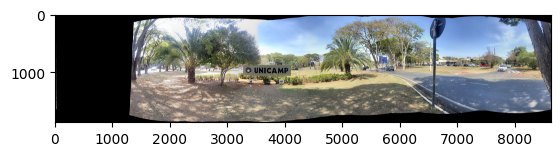

In [4]:
imgs = [heif2jpg(p) for p in scene_path]
stitcher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)  # ou cv.Stitcher_SCANS p/ cenas planas
status, pano = stitcher.stitch(imgs)
print(pano.shape)
plt.imshow(pano)

In [ ]:
import cv2
import numpy as np
from scipy.spatial import cKDTree
from scipy.optimize import least_squares
import warnings
class PanoramaStitcher:
    def __init__(self):
        self.sift = cv2.SIFT_create(nfeatures=3000)
        self.bf = cv2.BFMatcher(cv2.NORM_L2)
        self.images = []
        self.features = []
        self.matches = []
        self.homographies = []
        self.focal_lengths = []
        self.rotations = []
        self.gains = []

    def extract_features(self, image):
        """Extract SIFT features from an image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = self.sift.detectAndCompute(gray, None)
        return {'keypoints': kp, 'descriptors': desc}

    def match_features_kdtree(self, desc1, desc2, k=4):
        """Match features using k-d tree for approximate nearest neighbors"""
        if len(desc1) == 0 or len(desc2) == 0:
            return []

        # Build k-d tree for second image's descriptors
        tree = cKDTree(desc2)

        # Find k nearest neighbors for each descriptor in first image
        distances, indices = tree.query(desc1, k=k)

        # Lowe's ratio test
        good_matches = []
        for i, (dists, idxs) in enumerate(zip(distances, indices)):
            if k == 1:
                good_matches.append(cv2.DMatch(i, idxs, dists))
            elif dists[0] < 0.6 * dists[1]:  # Lowe's ratio test
                good_matches.append(cv2.DMatch(i, idxs[0], dists[0]))

        return good_matches

    def ransac_homography(self, src_pts, dst_pts, n_trials=500, threshold=5.0):
        """Estimate homography using RANSAC with probabilistic verification"""
        if len(src_pts) < 4:
            return None, None

        # Convert points to numpy arrays
        src_pts = np.float32(src_pts).reshape(-1, 2)
        dst_pts = np.float32(dst_pts).reshape(-1, 2)

        # RANSAC parameters
        best_H = None
        best_inliers = []
        max_inliers = 0

        for _ in range(n_trials):
            # Randomly select 4 point pairs
            idx = np.random.choice(len(src_pts), 4, replace=False)
            src_sample = src_pts[idx]
            dst_sample = dst_pts[idx]

            # Compute homography
            H, _ = cv2.findHomography(src_sample, dst_sample, 0)
            if H is None:
                continue

            # Transform all points
            ones = np.ones((len(src_pts), 1))
            src_hom = np.hstack((src_pts, ones))
            dst_proj = H @ src_hom.T
            dst_proj = (dst_proj[:2] / dst_proj[2]).T

            # Compute distances
            errors = np.linalg.norm(dst_pts - dst_proj, axis=1)
            inliers = errors < threshold

            # Update best model
            inlier_count = np.sum(inliers)
            if inlier_count > max_inliers:
                max_inliers = inlier_count
                best_inliers = inliers
                best_H = H

        # Probabilistic verification
        n_inliers = max_inliers
        n_total = len(src_pts)
        alpha = 8.0
        beta = 0.3

        if best_H is not None and np.sum(best_inliers) >= 4 and n_inliers > alpha + beta * n_total:
            # Refine homography with all inliers
            src_inliers = src_pts[best_inliers]
            dst_inliers = dst_pts[best_inliers]
            best_H, _ = cv2.findHomography(src_inliers, dst_inliers, cv2.RANSAC, threshold)
            return best_H, best_inliers
        else:
            return None, None

    def bundle_adjustment(self):
        """Joint optimization of all camera parameters"""
        if len(self.images) < 2:
            return

        # Initialize parameters: each image has rotation (3 params) and focal length (1 param)
        n_images = len(self.images)
        params = np.zeros(n_images * 4)

        # Set initial values
        for i in range(n_images):
            if i < len(self.rotations):
                rvec, _ = cv2.Rodrigues(self.rotations[i])
                params[i*4:i*4+3] = rvec.flatten()
            if i < len(self.focal_lengths):
                params[i*4+3] = self.focal_lengths[i]
            else:
                params[i*4+3] = self.focal_lengths[0] if self.focal_lengths else 1000.0

        # Optimize using Levenberg-Marquardt
        def residual(params):
            rotations = []
            focal_lengths = []
            for i in range(n_images):
                theta = params[i*4:i*4+3]
                R = cv2.Rodrigues(theta)[0]
                rotations.append(R)
                focal_lengths.append(params[i*4+3])

            residuals = []
            for match in self.matches:
                img_idx1, img_idx2 = match['image_indices']
                kp_idx1, kp_idx2 = match['keypoint_indices']

                kp1 = self.features[img_idx1]['keypoints'][kp_idx1].pt
                kp2 = self.features[img_idx2]['keypoints'][kp_idx2].pt

                K1 = np.array([
                    [focal_lengths[img_idx1], 0, 0],
                    [0, focal_lengths[img_idx1], 0],
                    [0, 0, 1]
                ])
                K2 = np.array([
                    [focal_lengths[img_idx2], 0, 0],
                    [0, focal_lengths[img_idx2], 0],
                    [0, 0, 1]
                ])

                H = K1 @ rotations[img_idx1] @ rotations[img_idx2].T @ np.linalg.inv(K2)
                point = np.array([kp2[0], kp2[1], 1])
                projected = H @ point
                projected = projected[:2] / projected[2]
                residual = np.array([kp1[0] - projected[0], kp1[1] - projected[1]])
                residuals.append(residual)

            return np.concatenate(residuals)

        # Run optimization
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            result = least_squares(residual, params, method='lm', max_nfev=100)

        # Update parameters
        for i in range(n_images):
            theta = result.x[i*4:i*4+3]
            self.rotations[i] = cv2.Rodrigues(theta)[0]
            self.focal_lengths[i] = result.x[i*4+3]

    def normalize_exposure(self, images):
        """Normalize exposure across images before stitching"""
        lab_images = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in images]

        # Calculate median L values (more robust than mean)
        l_medians = [np.median(img[:,:,0]) for img in lab_images]
        ref_median = np.median(l_medians)

        # Adjust each image
        normalized = []
        for img, l_median in zip(lab_images, l_medians):
            if l_median > 0:
                scale = ref_median / l_median
                # Apply more conservative scaling
                scale = np.clip(scale, 0.8, 1.2)
                img[:,:,0] = np.clip(img[:,:,0] * scale, 0, 255)
            normalized.append(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))

        return normalized

    def gain_compensation(self):
        """More conservative gain compensation"""
        n_images = len(self.images)
        if n_images < 2:
            self.gains = np.ones(n_images)
            return

        # Calculate median intensities in LAB color space
        median_intensities = []
        for img in self.images:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            median_intensities.append(np.median(lab[:,:,0]))

        # Use median intensity as reference
        reference_intensity = np.median(median_intensities)

        # Calculate gains relative to reference
        self.gains = []
        for intensity in median_intensities:
            if intensity > 0:
                gain = reference_intensity / intensity
                # Apply conservative clamping
                gain = np.clip(gain, 0.7, 1.3)
                self.gains.append(gain)
            else:
                self.gains.append(1.0)

    def apply_gain_compensation(self, img, gain):
        """Apply gain compensation with gamma correction for more natural results"""
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0].astype(np.float32)

        # Apply gain with gamma correction
        adjusted = 255 * (l_channel/255) ** (1/gain)

        lab[:,:,0] = np.clip(adjusted, 0, 255).astype(np.uint8)
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    def multi_band_blending(self, warped_images, masks, num_bands=5):
      """Blending de imagens com todas as bandas em LAB"""
      lab_images = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float32) for img in warped_images]

      blended_channels = []
      for c in range(3):  # L, a, b
          channel_stack = [img[:,:,c] for img in lab_images]
          blended_c = self._blend_pyramids(channel_stack, masks, num_bands)

          sum_masks = np.sum(masks, axis=0)
          blended_c[sum_masks == 0] = 128 if c > 0 else 0  # L=0, a/b=128
          blended_channels.append(blended_c)

      blended_lab = np.dstack(blended_channels).astype(np.uint8)
      blended_bgr = cv2.cvtColor(blended_lab, cv2.COLOR_LAB2BGR)
      return blended_bgr

    def _blend_pyramids(self, images, masks, num_bands):
        """Helper function for multi-band blending"""
        # Build Laplacian pyramids for each image
        pyramids = []
        for img, mask in zip(images, masks):
            # Build Gaussian pyramid for the mask
            mask_pyramid = [mask.astype(np.float32)]
            for _ in range(num_bands-1):
                mask_pyramid.append(cv2.pyrDown(mask_pyramid[-1]))

            # Build Laplacian pyramid for the image
            pyramid = [img.astype(np.float32)]
            for _ in range(num_bands-1):
                img_pyrDown = cv2.pyrDown(pyramid[-1])
                pyramid.append(img_pyrDown)

            # Convert to Laplacian pyramid
            for i in range(num_bands-1):
                size = (pyramid[i].shape[1], pyramid[i].shape[0])
                img_pyrUp = cv2.pyrUp(pyramid[i+1], dstsize=size)
                pyramid[i] -= img_pyrUp

            pyramids.append((pyramid, mask_pyramid))

        # Blend pyramids
        blended_pyramid = []
        for band in range(num_bands):
            blended = np.zeros_like(pyramids[0][0][band])
            sum_weights = np.zeros_like(pyramids[0][1][band])

            for pyramid, mask_pyramid in pyramids:
                blended += pyramid[band] * mask_pyramid[band]
                sum_weights += mask_pyramid[band]

            sum_weights[sum_weights == 0] = 1  # Avoid division by zero
            blended /= sum_weights
            blended_pyramid.append(blended)

        # Reconstruct from pyramid
        result = blended_pyramid[-1]
        for i in range(num_bands-2, -1, -1):
            size = (blended_pyramid[i].shape[1], blended_pyramid[i].shape[0])
            result = cv2.pyrUp(result, dstsize=size)
            result += blended_pyramid[i]

        return np.clip(result, 0, 255).astype(np.uint8)

    def adjust_tone(self, image):
        """Final tone adjustment with more conservative settings"""
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE with conservative settings
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        l = clahe.apply(l)

        # Apply mild gamma correction
        l = np.power(l.astype(np.float32)/255, 0.95) * 255
        l = np.clip(l, 0, 255).astype(np.uint8)

        # Merge channels back
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    def auto_crop(self, image):
        """Crop black borders from the image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return image

        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)

        return image[y:y+h, x:x+w]
    
    def stitch(self, images):
        """Main stitching pipeline with improved exposure handling"""
        # Normalize exposure first
        self.images = self.normalize_exposure(images)
        n_images = len(self.images)

        if n_images == 0:
            return None

        # Step 1: Feature extraction
        print("Extracting features...")
        self.features = [self.extract_features(img) for img in self.images]

        # Step 2: Feature matching
        print("Matching features...")
        self.matches = []
        for i in range(n_images):
            for j in range(i+1, n_images):
                matches = self.match_features_kdtree(
                    self.features[i]['descriptors'],
                    self.features[j]['descriptors']
                )

                if len(matches) < 4:
                    continue

                src_pts = np.float32([self.features[i]['keypoints'][m.queryIdx].pt for m in matches])
                dst_pts = np.float32([self.features[j]['keypoints'][m.trainIdx].pt for m in matches])

                #H, inliers = self.ransac_homography(src_pts, dst_pts)
                H, inliers = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5.0)

                if H is not None:
                    inlier_matches = [matches[k] for k in range(len(matches)) if inliers[k]]
                    for m in inlier_matches:
                        self.matches.append({
                            'image_indices': (i, j),
                            'keypoint_indices': (m.queryIdx, m.trainIdx)
                        })

        # Step 3: Initialize camera parameters
        print("Initializing camera parameters...")
        self.focal_lengths = [1000.0] * n_images
        self.rotations = [np.eye(3) for _ in range(n_images)]

        # Step 4: Bundle adjustment
        print("Running bundle adjustment...")
        self.bundle_adjustment()
        

        # Step 5: Gain compensation
        print("Computing gain compensation...")
        self.gain_compensation()
        print("Computed gains:", self.gains)

        # Step 6: Warp images and blend
        print("Warping and blending images...")

        ref_idx = n_images // 2
        h_ref, w_ref = self.images[ref_idx].shape[:2]

        K_ref = np.array([
            [self.focal_lengths[ref_idx], 0, 0],
            [0, self.focal_lengths[ref_idx], 0],
            [0, 0, 1]
        ])

        # Compute panorama bounding box
        corners = []
        for i in range(n_images):
            h_i, w_i = self.images[i].shape[:2]
            pts = np.array([[0, 0], [w_i, 0], [w_i, h_i], [0, h_i]], dtype=np.float32).reshape(-1, 1, 2)

            K_i = np.array([
                [self.focal_lengths[i], 0, 0],
                [0, self.focal_lengths[i], 0],
                [0, 0, 1]
            ])
            H = K_ref @ self.rotations[ref_idx] @ self.rotations[i].T @ np.linalg.inv(K_i)

            warped_corners = cv2.perspectiveTransform(pts, H)
            corners.append(warped_corners)

        all_corners = np.vstack(corners)
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

        shift = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        canvas_size = (x_max - x_min, y_max - y_min)

        # Warp all images with compensation
        warped_images = []
        masks = []
        for i in range(n_images):
            K_i = np.array([
                [self.focal_lengths[i], 0, 0],
                [0, self.focal_lengths[i], 0],
                [0, 0, 1]
            ])
            H = K_ref @ self.rotations[ref_idx] @ self.rotations[i].T @ np.linalg.inv(K_i)

            img = self.apply_gain_compensation(self.images[i], self.gains[i])
            warped = cv2.warpPerspective(img, shift @ H, canvas_size)
            warped_images.append(warped)

            mask = np.ones((self.images[i].shape[0], self.images[i].shape[1]), dtype=np.uint8) * 255
            warped_mask = cv2.warpPerspective(mask, shift @ H, canvas_size)
            masks.append((warped_mask > 0).astype(np.float32))

        # Multi-band blending
        panorama = self.multi_band_blending(warped_images, masks)

        # Final tone adjustment
        
        #panorama = self.adjust_tone(panorama)

        # Auto-crop borders
        #panorama = self.auto_crop(panorama)

        return panorama

In [ ]:
# Create and run stitcher
stitcher = PanoramaStitcher()
imgs = [cv2.resize(heif2jpg(p), (0, 0), fx=0.5, fy=0.5) for p in scene_path]
panorama = stitcher.stitch(imgs[:3])

if panorama is not None:
    plt.imshow(panorama)

## Nova implementação

In [121]:
import cv2
import numpy as np
from scipy.spatial import cKDTree
from scipy.optimize import least_squares
import warnings

class PanoramaStitcher:
    def __init__(self):
        self.sift = cv2.SIFT_create(nfeatures=1000)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=25)  # Aumentar para mais precisão, diminuir para mais velocidade

        self.bf = cv2.FlannBasedMatcher(index_params, search_params)
        self.images = []
        self.features = []
        self.matches = []
        self.homographies = []
        self.focal_lengths = []
        self.rotations = []
        self.gains = []

    def extract_features(self, image):
        """Extract SIFT features from an image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = self.sift.detectAndCompute(gray, None)
        return {'keypoints': kp, 'descriptors': desc}

    def match_features_flann(self, desc1, desc2):
        """
        Encontra os melhores matches entre dois descritores usando FLANN.
        """
        if desc1 is None or desc2 is None or len(desc1) < 2 or len(desc2) < 2:
            return []
        
        # Usa knnMatch para encontrar os 2 vizinhos mais próximos de forma eficiente
        matches = self.bf.knnMatch(desc1, desc2, k=4)

        # Aplica o teste de proporção de Lowe para filtrar matches ruins
        good_matches = []
        for match_list in matches:
            # Garante que temos um par de matches para comparar
            if len(match_list) >= 2:
                m, n = match_list[0], match_list[1] # Extrai o primeiro e o segundo vizinho
                if m.distance < 0.60 * n.distance:
                    good_matches.append(m)
        
        return good_matches

    def ransac_homography(self, src_pts, dst_pts, n_trials=500, threshold=5.0):
        """Estimate homography using RANSAC with probabilistic verification"""
        if len(src_pts) < 4:
            return None, None

        # Convert points to numpy arrays
        src_pts = np.float32(src_pts).reshape(-1, 2)
        dst_pts = np.float32(dst_pts).reshape(-1, 2)

        # RANSAC parameters
        best_H = None
        best_inliers = []
        max_inliers = 0

        for _ in range(n_trials):
            # Randomly select 4 point pairs
            idx = np.random.choice(len(src_pts), 4, replace=False)
            src_sample = src_pts[idx]
            dst_sample = dst_pts[idx]

            # Compute homography
            H, _ = cv2.findHomography(src_sample, dst_sample, 0)
            if H is None:
                continue

            # Transform all points
            ones = np.ones((len(src_pts), 1))
            src_hom = np.hstack((src_pts, ones))
            dst_proj = H @ src_hom.T
            dst_proj = (dst_proj[:2] / dst_proj[2]).T

            # Compute distances
            errors = np.linalg.norm(dst_pts - dst_proj, axis=1)
            inliers = errors < threshold

            # Update best model
            inlier_count = np.sum(inliers)
            if inlier_count > max_inliers:
                max_inliers = inlier_count
                best_inliers = inliers
                best_H = H

        # Probabilistic verification
        n_inliers = max_inliers
        n_total = len(src_pts)
        alpha = 8.0
        beta = 0.3

        if best_H is not None and np.sum(best_inliers) >= 4 and n_inliers > alpha + beta * n_total:
            # Refine homography with all inliers
            src_inliers = src_pts[best_inliers]
            dst_inliers = dst_pts[best_inliers]
            best_H, _ = cv2.findHomography(src_inliers, dst_inliers, cv2.RANSAC, threshold)
            return best_H, best_inliers
        else:
            return None, None

    def bundle_adjustment(self):
        """Joint optimization of all camera parameters"""
        if len(self.images) < 2:
            return

        # Initialize parameters: each image has rotation (3 params) and focal length (1 param)
        n_images = len(self.images)
        params = np.zeros(n_images * 4)

        # Set initial values
        for i in range(n_images):
            if i < len(self.rotations):
                rvec, _ = cv2.Rodrigues(self.rotations[i])
                params[i*4:i*4+3] = rvec.flatten()
            if i < len(self.focal_lengths):
                params[i*4+3] = self.focal_lengths[i]
            else:
                params[i*4+3] = self.focal_lengths[0] if self.focal_lengths else 1000.0

        # Optimize using Levenberg-Marquardt
        def residual(params):
            rotations = []
            focal_lengths = []
            for i in range(n_images):
                theta = params[i*4:i*4+3]
                R = cv2.Rodrigues(theta)[0]
                rotations.append(R)
                focal_lengths.append(params[i*4+3])

            residuals = []
            for match in self.matches:
                img_idx1, img_idx2 = match['image_indices']
                kp_idx1, kp_idx2 = match['keypoint_indices']

                kp1 = self.features[img_idx1]['keypoints'][kp_idx1].pt
                kp2 = self.features[img_idx2]['keypoints'][kp_idx2].pt

                K1 = np.array([
                    [focal_lengths[img_idx1], 0, 0],
                    [0, focal_lengths[img_idx1], 0],
                    [0, 0, 1]
                ])
                K2 = np.array([
                    [focal_lengths[img_idx2], 0, 0],
                    [0, focal_lengths[img_idx2], 0],
                    [0, 0, 1]
                ])

                H = K1 @ rotations[img_idx1] @ rotations[img_idx2].T @ np.linalg.inv(K2)
                point = np.array([kp2[0], kp2[1], 1])
                projected = H @ point
                projected = projected[:2] / projected[2]
                residual = np.array([kp1[0] - projected[0], kp1[1] - projected[1]])
                residuals.append(residual)

            return np.concatenate(residuals)

        # Run optimization
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            result = least_squares(residual, params, method='lm', max_nfev=100)

        # Update parameters
        for i in range(n_images):
            theta = result.x[i*4:i*4+3]
            self.rotations[i] = cv2.Rodrigues(theta)[0]
            self.focal_lengths[i] = result.x[i*4+3]

    def normalize_exposure(self, images):
        """Normalize exposure across images before stitching"""
        lab_images = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in images]

        # Calculate median L values (more robust than mean)
        l_medians = [np.median(img[:,:,0]) for img in lab_images]
        ref_median = np.median(l_medians)

        # Adjust each image
        normalized = []
        for img, l_median in zip(lab_images, l_medians):
            if l_median > 0:
                scale = ref_median / l_median
                # Apply more conservative scaling
                scale = np.clip(scale, 0.8, 1.2)
                img[:,:,0] = np.clip(img[:,:,0] * scale, 0, 255)
            normalized.append(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))

        return normalized

    def gain_compensation(self):
        """More conservative gain compensation"""
        n_images = len(self.images)
        if n_images < 2:
            self.gains = np.ones(n_images)
            return

        # Calculate median intensities in LAB color space
        median_intensities = []
        for img in self.images:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            median_intensities.append(np.median(lab[:,:,0]))

        # Use median intensity as reference
        reference_intensity = np.median(median_intensities)

        # Calculate gains relative to reference
        self.gains = []
        for intensity in median_intensities:
            if intensity > 0:
                gain = reference_intensity / intensity
                # Apply conservative clamping
                gain = np.clip(gain, 0.7, 1.3)
                self.gains.append(gain)
            else:
                self.gains.append(1.0)

    def apply_gain_compensation(self, img, gain):
        """Apply gain compensation with gamma correction for more natural results"""
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0].astype(np.float32)

        # Apply gain with gamma correction
        adjusted = 255 * (l_channel/255) ** (1/gain)

        lab[:,:,0] = np.clip(adjusted, 0, 255).astype(np.uint8)
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    def straighten_panorama(self):
        """
        Endireita o panorama calculando uma rotação global de correção.
        Esta técnica baseia-se na heurística de que os eixos X das câmaras
        tendem a situar-se num plano comum.
        """
        print("Straightening panorama...")

        # 1. Obter todos os vetores X da câmara (primeira coluna de cada matriz de rotação)
        camera_x_vectors = []
        for r in self.rotations:
            # O vetor X é a primeira coluna da matriz de rotação
            camera_x_vectors.append(r[:, 0])
        
        camera_x_vectors = np.array(camera_x_vectors)

        # 2. Calcular a matriz de covariância
        # C = X^T * X
        covariance_matrix = camera_x_vectors.T @ camera_x_vectors

        # 3. Encontrar o autovetor associado ao menor autovalor
        # Este é o nosso "vetor para cima" (u), que é normal ao plano dos vetores X.
        eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
        up_vector = eigen_vectors[:, np.argmin(eigen_values)]

        # 4. Calcular a rotação para alinhar o nosso 'up_vector' com o eixo Y vertical [0, 1, 0]
        # O eixo de rotação é o produto vetorial entre os dois vetores
        rotation_axis = np.cross(up_vector, [0, 1, 0])
        rotation_axis /= np.linalg.norm(rotation_axis) # Normalizar

        # O ângulo de rotação é o arco-cosseno do produto escalar
        angle = np.arccos(np.dot(up_vector, [0, 1, 0]))

        # Criar a matriz de rotação global de correção usando a fórmula de Rodrigues
        # (que converte de eixo-ângulo para matriz de rotação)
        R_straight, _ = cv2.Rodrigues(rotation_axis * angle)

        # 5. Aplicar esta rotação de correção a todas as câmaras
        for i in range(len(self.rotations)):
            self.rotations[i] = R_straight @ self.rotations[i]
    
    def feathering(self, warped_images, masks, blend_width=20):
      """
      Mescla imagens usando feathering com largura de blend ajustável.

      Args:
          warped_images: Lista de imagens distorcidas.
          masks: Lista de máscaras correspondentes.
          blend_width: Largura da área de suavização (em pixels). 
                      Valores maiores criam um blend mais suave. Use um número par.
      """
      if not warped_images:
          return None

      canvas_size = warped_images[0].shape
      result = np.zeros(canvas_size, dtype=np.float32)
      total_weight = np.zeros(canvas_size, dtype=np.float32)

      # O kernel controla o quanto a máscara será "encolhida" (erodida)
      # Um kernel maior resulta em um blend mais largo
      kernel_size = blend_width + 1 if blend_width % 2 == 0 else blend_width # Garante que seja ímpar
      kernel = np.ones((kernel_size, kernel_size), np.uint8)

      for img, mask in zip(warped_images, masks):
          mask_uint8 = (mask * 255).astype(np.uint8)
          
          # Erodindo a máscara para criar uma zona de transição mais larga
          eroded_mask = cv2.erode(mask_uint8, kernel, iterations=1)

          # O peso é a distância da borda da máscara erodida
          weight = cv2.distanceTransform(eroded_mask, cv2.DIST_L2, 5).astype(np.float32)
          
          # Normalizar o peso para o intervalo [0, 1]
          max_val = np.max(weight)
          if max_val > 0:
              weight /= max_val
          
          weight = cv2.merge([weight] * 3) # Expandir para 3 canais

          result += img.astype(np.float32) * weight
          total_weight += weight

      # Evitar divisão por zero
      mask_div = total_weight > 1e-6
      blended_panorama = np.zeros_like(result, dtype=np.float32)
      np.divide(result, total_weight, out=blended_panorama, where=mask_div)

      return np.clip(blended_panorama, 0, 255).astype(np.uint8)

    def adjust_tone(self, image):
        """Final tone adjustment with more conservative settings"""
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE with conservative settings
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        l = clahe.apply(l)

        # Apply mild gamma correction
        l = np.power(l.astype(np.float32)/255, 0.95) * 255
        l = np.clip(l, 0, 255).astype(np.uint8)

        # Merge channels back
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    def auto_crop(self, image):
        """Crop black borders from the image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return image

        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)

        return image[y:y+h, x:x+w]
    
    def stitch(self, images):
        """Main stitching pipeline with improved exposure handling"""
        # Normalize exposure first
        self.images = self.normalize_exposure(images)
        n_images = len(self.images)

        if n_images == 0:
            return None

        # Step 1: Feature extraction
        print("Extracting features...")
        self.features = [self.extract_features(img) for img in self.images]

        # Step 2: Feature matching
        print("Matching features...")
        self.matches = []
        for i in range(n_images):
            for j in range(i+1, n_images):
                matches = self.match_features_flann(
                    self.features[i]['descriptors'],
                    self.features[j]['descriptors']
                )

                if len(matches) < 4:
                    continue

                src_pts = np.float32([self.features[i]['keypoints'][m.queryIdx].pt for m in matches])
                dst_pts = np.float32([self.features[j]['keypoints'][m.trainIdx].pt for m in matches])

                #changing threshold to 3
                H, inliers = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=1.5)

                if H is not None:
                    inlier_matches = [matches[k] for k in range(len(matches)) if inliers[k]]
                    for m in inlier_matches:
                        self.matches.append({
                            'image_indices': (i, j),
                            'keypoint_indices': (m.queryIdx, m.trainIdx)
                        })

        # Step 3: Initialize camera parameters
        print("Initializing camera parameters...")
        self.focal_lengths = [1000.0] * n_images
        self.rotations = [np.eye(3) for _ in range(n_images)]

        # Step 4: Bundle adjustment
        print("Running bundle adjustment...")
        self.bundle_adjustment()
        self.straighten_panorama()
        # Step 5: Gain compensation
        print("Computing gain compensation...")
        self.gain_compensation()
        print("Computed gains:", self.gains)

        # Step 6: Warp images and blend
        print("Warping and blending images...")

        ref_idx = n_images // 2
        h_ref, w_ref = self.images[ref_idx].shape[:2]

        K_ref = np.array([
            [self.focal_lengths[ref_idx], 0, 0],
            [0, self.focal_lengths[ref_idx], 0],
            [0, 0, 1]
        ])

        # Compute panorama bounding box
        corners = []
        for i in range(n_images):
            h_i, w_i = self.images[i].shape[:2]
            pts = np.array([[0, 0], [w_i, 0], [w_i, h_i], [0, h_i]], dtype=np.float32).reshape(-1, 1, 2)

            K_i = np.array([
                [self.focal_lengths[i], 0, 0],
                [0, self.focal_lengths[i], 0],
                [0, 0, 1]
            ])
            H = K_ref @ self.rotations[ref_idx] @ self.rotations[i].T @ np.linalg.inv(K_i)

            warped_corners = cv2.perspectiveTransform(pts, H)
            corners.append(warped_corners)

        all_corners = np.vstack(corners)
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

        shift = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        canvas_size = (x_max - x_min, y_max - y_min)

        # Warp all images with compensation
        warped_images = []
        masks = []
        for i in range(n_images):
            K_i = np.array([
                [self.focal_lengths[i], 0, 0],
                [0, self.focal_lengths[i], 0],
                [0, 0, 1]
            ])
            H = K_ref @ self.rotations[ref_idx] @ self.rotations[i].T @ np.linalg.inv(K_i)

            img = self.apply_gain_compensation(self.images[i], self.gains[i])
            warped = cv2.warpPerspective(img, shift @ H, canvas_size)
            warped_images.append(warped)

            mask = np.ones((self.images[i].shape[0], self.images[i].shape[1]), dtype=np.uint8) * 255
            warped_mask = cv2.warpPerspective(mask, shift @ H, canvas_size)
            masks.append((warped_mask > 0).astype(np.float32))

        # Use Feather Blending instead of Multi-band
        panorama = self.feathering(warped_images, masks, 20)

        # Optional post-processing
        # panorama = self.adjust_tone(panorama)
        # panorama = self.auto_crop(panorama)

        return panorama

Extracting features...
Matching features...
Initializing camera parameters...
Running bundle adjustment...
Straightening panorama...
Computing gain compensation...
Computed gains: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9935897435897436), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Warping and blending images...


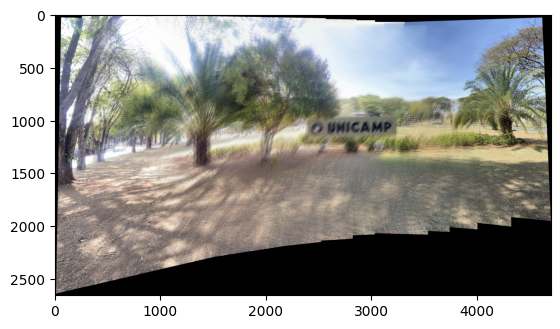

In [122]:

# Create and run stitcher
stitcher = PanoramaStitcher()
imgs = [cv2.resize(heif2jpg(p), (0, 0), fx=1, fy=1) for p in scene_path]
panorama = stitcher.stitch(imgs[:12])

if panorama is not None:
    plt.imshow(panorama)

In [123]:
def sharpen_panorama(image, amount=2, kernel_size=(15,15)):
    """
    Aplica um filtro de nitidez (Unsharp Masking) a uma imagem.

    Args:
        image: A imagem de entrada (o panorama final).
        amount: A força do efeito de nitidez. Valores comuns: 0.5 (suave) a 1.5 (forte).
        kernel_size: O tamanho do kernel para o desfoque Gaussiano. Deve ser ímpar.
    """
    # Cria a versão desfocada da imagem
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    
    # Usa cv2.addWeighted para adicionar os detalhes de volta à imagem original
    # A fórmula é: original * (1 + amount) + blurred * (-amount)
    sharpened = cv2.addWeighted(image, 1.0 + amount, blurred, -amount, 0)
    
    return sharpened


cv2.imwrite('sharp.jpg', cv2.cvtColor(sharpen_panorama(stitcher.adjust_tone(panorama)), cv2.COLOR_RGB2BGR))

True

True

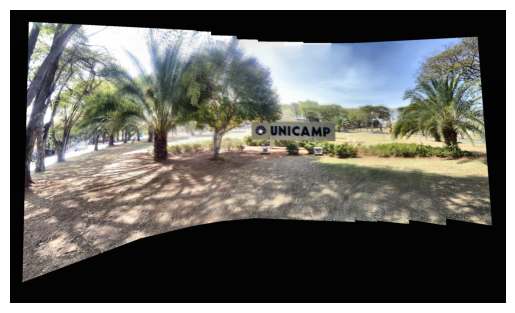

In [89]:
plt.imshow(stitcher.adjust_tone(panorama))
plt.axis('off')
cv2.imwrite('placa_feathering_tone_120.jpg', cv2.cvtColor(stitcher.adjust_tone(panorama), cv2.COLOR_RGB2BGR))

In [44]:
cv2.imwrite('placa_feathering.jpg', cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR))

True

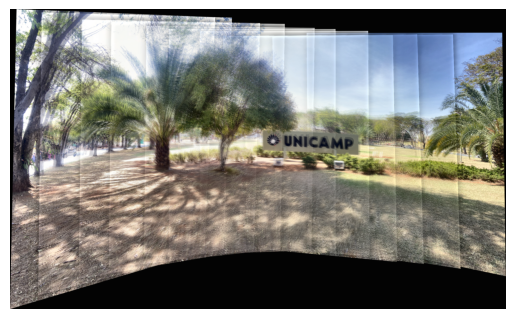

In [11]:
plt.imshow(panorama)
plt.axis('off')
plt.savefig('result_placa.jpg')

True

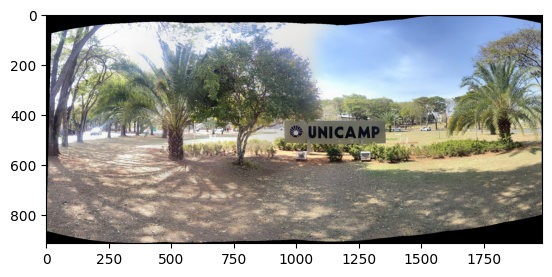

In [57]:
stitch = cv2.Stitcher_create()
status, pano= stitch.stitch(imgs[:12])
plt.imshow(pano)
cv2.imwrite('placa_baseline.jpg', cv2.cvtColor(pano, cv2.COLOR_RGB2BGR))

## Multibleng

In [ ]:
import cv2
import numpy as np
from scipy.spatial import cKDTree
from scipy.optimize import least_squares
import warnings

class PanoramaStitcher:
    def __init__(self):
        # AÇÃO 1: Aumentado drasticamente o número de features para melhor detecção
        self.sift = cv2.SIFT_create(nfeatures=15000) 
        self.bf = cv2.BFMatcher(cv2.NORM_L2)
        self.images = []
        self.features = []
        self.matches = []
        self.homographies = []
        self.focal_lengths = []
        self.rotations = []
        self.gains = []

    def extract_features(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = self.sift.detectAndCompute(gray, None)
        return {'keypoints': kp, 'descriptors': desc}

    def match_features_kdtree(self, desc1, desc2, k=2):
        if desc1 is None or desc2 is None or len(desc1) == 0 or len(desc2) == 0:
            return []
        tree = cKDTree(desc2)
        distances, indices = tree.query(desc1, k=k)
        good_matches = []
        for i, (dists, idxs) in enumerate(zip(distances, indices)):
            if k == 1:
                good_matches.append(cv2.DMatch(i, idxs, dists))
            elif len(dists) > 1 and dists[0] < 0.7 * dists[1]:
                good_matches.append(cv2.DMatch(i, idxs[0], dists[0]))
        return good_matches

    def ransac_homography(self, src_pts, dst_pts, n_trials=500, threshold=5.0):
        if len(src_pts) < 4:
            return None, None
        src_pts = np.float32(src_pts).reshape(-1, 2)
        dst_pts = np.float32(dst_pts).reshape(-1, 2)
        best_H = None
        best_inliers = []
        max_inliers = 0
        for _ in range(n_trials):
            idx = np.random.choice(len(src_pts), 4, replace=False)
            src_sample = src_pts[idx]
            dst_sample = dst_pts[idx]
            H, _ = cv2.findHomography(src_sample, dst_sample, 0)
            if H is None:
                continue
            ones = np.ones((len(src_pts), 1))
            src_hom = np.hstack((src_pts, ones))
            dst_proj = H @ src_hom.T
            dst_proj = (dst_proj[:2] / dst_proj[2]).T
            errors = np.linalg.norm(dst_pts - dst_proj, axis=1)
            inliers = errors < threshold
            inlier_count = np.sum(inliers)
            if inlier_count > max_inliers:
                max_inliers = inlier_count
                best_inliers = inliers
                best_H = H
        n_inliers = max_inliers
        n_total = len(src_pts)
        alpha = 8.0
        beta = 0.3
        if best_H is not None and np.sum(best_inliers) >= 4 and n_inliers > alpha + beta * n_total:
            src_inliers = src_pts[best_inliers]
            dst_inliers = dst_pts[best_inliers]
            best_H, _ = cv2.findHomography(src_inliers, dst_inliers, cv2.RANSAC, threshold)
            return best_H, best_inliers
        else:
            return None, None

    def bundle_adjustment(self):
        if len(self.images) < 2:
            return
        n_images = len(self.images)
        params = np.zeros(n_images * 4)
        for i in range(n_images):
            if i < len(self.rotations):
                rvec, _ = cv2.Rodrigues(self.rotations[i])
                params[i*4:i*4+3] = rvec.flatten()
            if i < len(self.focal_lengths):
                params[i*4+3] = self.focal_lengths[i]
            else:
                params[i*4+3] = self.focal_lengths[0] if self.focal_lengths else 1000.0
        def residual(params):
            rotations = []
            focal_lengths = []
            for i in range(n_images):
                theta = params[i*4:i*4+3]
                R = cv2.Rodrigues(theta)[0]
                rotations.append(R)
                focal_lengths.append(params[i*4+3])
            residuals = []
            for match in self.matches:
                img_idx1, img_idx2 = match['image_indices']
                kp_idx1, kp_idx2 = match['keypoint_indices']
                kp1 = self.features[img_idx1]['keypoints'][kp_idx1].pt
                kp2 = self.features[img_idx2]['keypoints'][kp_idx2].pt
                K1 = np.array([[focal_lengths[img_idx1], 0, 0], [0, focal_lengths[img_idx1], 0], [0, 0, 1]])
                K2 = np.array([[focal_lengths[img_idx2], 0, 0], [0, focal_lengths[img_idx2], 0], [0, 0, 1]])
                H = K1 @ rotations[img_idx1] @ rotations[img_idx2].T @ np.linalg.inv(K2)
                point = np.array([kp2[0], kp2[1], 1])
                projected = H @ point
                projected = projected[:2] / projected[2]
                residual = np.array([kp1[0] - projected[0], kp1[1] - projected[1]])
                residuals.append(residual)
            return np.concatenate(residuals)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            # AÇÃO 1: Aumentado max_nfev para mais iterações no Bundle Adjustment
            result = least_squares(residual, params, method='lm', max_nfev=200) 
        for i in range(n_images):
            theta = result.x[i*4:i*4+3]
            self.rotations[i] = cv2.Rodrigues(theta)[0]
            self.focal_lengths[i] = result.x[i*4+3]

    def normalize_exposure(self, images):
        lab_images = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in images]
        l_medians = [np.median(img[:,:,0]) for img in lab_images]
        ref_median = np.median(l_medians)
        normalized = []
        for img, l_median in zip(lab_images, l_medians):
            if l_median > 0:
                scale = ref_median / l_median
                scale = np.clip(scale, 0.8, 1.2)
                img[:,:,0] = np.clip(img[:,:,0] * scale, 0, 255)
            normalized.append(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))
        return normalized

    def gain_compensation(self):
        n_images = len(self.images)
        if n_images < 2:
            self.gains = np.ones(n_images)
            return
        median_intensities = []
        for img in self.images:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            median_intensities.append(np.median(lab[:,:,0]))
        reference_intensity = np.median(median_intensities)
        self.gains = []
        for intensity in median_intensities:
            if intensity > 0:
                gain = reference_intensity / intensity
                gain = np.clip(gain, 0.7, 1.3)
                self.gains.append(gain)
            else:
                self.gains.append(1.0)

    def apply_gain_compensation(self, img, gain):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0].astype(np.float32)
        adjusted = 255 * (l_channel/255) ** (1/gain)
        lab[:,:,0] = np.clip(adjusted, 0, 255).astype(np.uint8)
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    def multi_band_blending(self, warped_images, masks, num_levels=5):
        images = [img.astype(np.float32) for img in warped_images]
        masks = [m.astype(np.float32) for m in masks]
        
        mask_pyramids = []
        for mask in masks:
            pyramid = [mask]
            for _ in range(num_levels - 1):
                pyramid.append(cv2.pyrDown(pyramid[-1]))
            mask_pyramids.append(pyramid)
        
        laplacian_pyramids = []
        for img in images:
            gaussian_pyramid = [img]
            for _ in range(num_levels - 1):
                gaussian_pyramid.append(cv2.pyrDown(gaussian_pyramid[-1]))
            
            laplacian_pyramid = [gaussian_pyramid[num_levels - 1]]
            for i in range(num_levels - 1, 0, -1):
                size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])
                upsampled = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
                laplacian = cv2.subtract(gaussian_pyramid[i-1], upsampled)
                laplacian_pyramid.insert(0, laplacian)
            laplacian_pyramids.append(laplacian_pyramid)

        blended_pyramid = []
        for i in range(num_levels):
            blended_level = np.zeros_like(laplacian_pyramids[0][i])
            total_weight = np.zeros_like(laplacian_pyramids[0][i]) # Corrigido para 3 canais
            
            for j in range(len(images)):
                mask = mask_pyramids[j][i]
                if mask.ndim == 2:
                    mask = cv2.merge([mask, mask, mask])

                blended_level += laplacian_pyramids[j][i] * mask
                total_weight += mask
            
            total_weight[total_weight == 0] = 1.0 # Evita divisão por zero
            blended_level /= total_weight
            blended_pyramid.append(blended_level)

        result = blended_pyramid[num_levels - 1]
        for i in range(num_levels - 1, 0, -1):
            size = (blended_pyramid[i-1].shape[1], blended_pyramid[i-1].shape[0])
            result = cv2.pyrUp(result, dstsize=size)
            result = cv2.add(result, blended_pyramid[i-1])

        return np.clip(result, 0, 255).astype(np.uint8)

    def adjust_tone(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        l = np.power(l.astype(np.float32)/255, 0.95) * 255
        l = np.clip(l, 0, 255).astype(np.uint8)
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    def auto_crop(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return image
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        return image[y:y+h, x:x+w]
    
    def stitch(self, images):
        self.images = self.normalize_exposure(images)
        n_images = len(self.images)
        if n_images == 0:
            return None
        print("Extracting features...")
        self.features = [self.extract_features(img) for img in self.images]
        print("Matching features...")
        self.matches = []
        for i in range(n_images):
            for j in range(i+1, n_images):
                matches = self.match_features_kdtree(
                    self.features[i]['descriptors'],
                    self.features[j]['descriptors']
                )
                if len(matches) < 4:
                    continue
                src_pts = np.float32([self.features[i]['keypoints'][m.queryIdx].pt for m in matches])
                dst_pts = np.float32([self.features[j]['keypoints'][m.trainIdx].pt for m in matches])
                
                # AÇÃO 1: Reduzido o threshold do RANSAC para maior rigor no alinhamento
                H, inliers = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=1.5) 

                if H is not None and inliers is not None:
                    inlier_matches = [matches[k] for k in range(len(matches)) if inliers[k]]
                    for m in inlier_matches:
                        self.matches.append({
                            'image_indices': (i, j),
                            'keypoint_indices': (m.queryIdx, m.trainIdx)
                        })
        print("Initializing camera parameters...")
        self.focal_lengths = [1000.0] * n_images
        self.rotations = [np.eye(3) for _ in range(n_images)]
        print("Running bundle adjustment...")
        self.bundle_adjustment()
        print("Computing gain compensation...")
        self.gain_compensation()
        print("Computed gains:", self.gains)
        print("Warping and blending images...")
        ref_idx = n_images // 2
        K_ref = np.array([[self.focal_lengths[ref_idx], 0, 0], [0, self.focal_lengths[ref_idx], 0], [0, 0, 1]])
        corners = []
        for i in range(n_images):
            h_i, w_i = self.images[i].shape[:2]
            pts = np.array([[0, 0], [w_i, 0], [w_i, h_i], [0, h_i]], dtype=np.float32).reshape(-1, 1, 2)
            K_i = np.array([[self.focal_lengths[i], 0, 0], [0, self.focal_lengths[i], 0], [0, 0, 1]])
            H = K_ref @ self.rotations[ref_idx] @ self.rotations[i].T @ np.linalg.inv(K_i)
            warped_corners = cv2.perspectiveTransform(pts, H)
            corners.append(warped_corners)
        all_corners = np.vstack(corners)
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
        shift = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        canvas_size = (x_max - x_min, y_max - y_min)
        warped_images = []
        masks = []
        for i in range(n_images):
            K_i = np.array([[self.focal_lengths[i], 0, 0], [0, self.focal_lengths[i], 0], [0, 0, 1]])
            H = K_ref @ self.rotations[ref_idx] @ self.rotations[i].T @ np.linalg.inv(K_i)
            img = self.apply_gain_compensation(self.images[i], self.gains[i])
            warped = cv2.warpPerspective(img, shift @ H, canvas_size)
            warped_images.append(warped)
            
            # AÇÃO 2: Gerar máscaras com transições suaves para o blending
            mask = np.ones((self.images[i].shape[0], self.images[i].shape[1]), dtype=np.uint8) * 255
            warped_mask = cv2.warpPerspective(mask, shift @ H, canvas_size, flags=cv2.INTER_NEAREST)
            
            # Aplicar desfoque Gaussiano na máscara para transições suaves
            # Kernel (15,15) é um bom ponto de partida, ajuste conforme necessidade
            blurred_mask = cv2.GaussianBlur(warped_mask.astype(np.float32), (15, 15), 0)
            masks.append(blurred_mask / 255.0) # Normalizar para [0, 1]

        print("Blending images with Multi-Band Blending for high quality...")
        panorama = self.multi_band_blending(warped_images, masks)
        
        # Opcional: auto-crop no final (descomente se quiser)
        # print("Cropping panorama...")
        # panorama = self.auto_crop(panorama)

        return panorama

Extracting features...
Matching features...
Initializing camera parameters...
Running bundle adjustment...
Computing gain compensation...
Computed gains: [np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Warping and blending images...
Blending images with Multi-Band Blending for high quality...


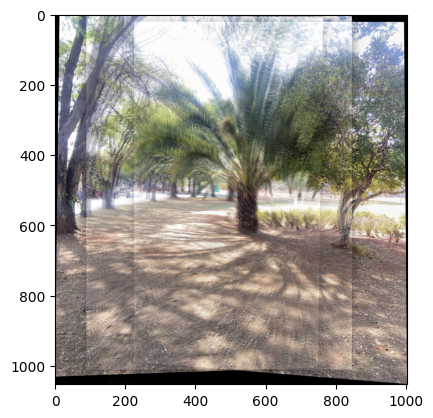

In [64]:

# Create and run stitcher
stitcher = PanoramaStitcher()
imgs = [cv2.resize(heif2jpg(p), (0, 0), fx=0.5, fy=0.5) for p in scene_path]
panorama = stitcher.stitch(imgs[:3])

if panorama is not None:
    plt.imshow(panorama)

## warped_image

In [10]:
import cv2
import numpy as np
from scipy.spatial import cKDTree
from scipy.optimize import least_squares
import warnings

class PanoramaStitcher:
    def __init__(self):
        self.sift = cv2.SIFT_create(nfeatures=500)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50) # Aumentei um pouco para maior precisão
        self.bf = cv2.FlannBasedMatcher(index_params, search_params)
        self.images = []
        self.features = []
        self.matches = []
        self.homographies = []
        self.focal_lengths = []
        self.rotations = []
        self.gains = []

    # A função de projeção cilíndrica não é mais necessária no início,
    # mas pode ser útil para outras aplicações. Mantida por completude.
    def cylindrical_projection(self, image, f=None):
        h, w = image.shape[:2]
        cx, cy = w / 2.0, h / 2.0
        if f is None:
            f = 0.8 * max(w, h)

        map_x = np.zeros((h, w), dtype=np.float32)
        map_y = np.zeros((h, w), dtype=np.float32)

        xs = np.arange(w).astype(np.float32)
        ys = np.arange(h).astype(np.float32)
        xv, yv = np.meshgrid(xs, ys)

        x_c = xv - cx
        y_c = yv - cy

        theta = x_c / f
        X = f * np.tan(theta)
        Y = y_c * np.sqrt(X**2 + f**2) / f

        src_x = X + cx
        src_y = Y + cy

        map_x[:, :] = src_x
        map_y[:, :] = src_y

        proj = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        gray = cv2.cvtColor(proj, cv2.COLOR_BGR2GRAY)
        mask = (gray > 0).astype(np.uint8) * 255

        return proj, mask, f

    def wave_correction(self, panorama, mask=None, poly_degree=3, smooth_sigma=25):
        if mask is None:
            gray_pano = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
            mask = (gray_pano > 0).astype(np.uint8)

        h, w = mask.shape
        centerline = np.zeros(w, dtype=np.float32)
        for col in range(w):
            rows = np.where(mask[:, col])[0]
            if len(rows) > 0:
                centerline[col] = np.mean(rows)
            else:
                # Se não houver pontos, tente usar o vizinho anterior
                centerline[col] = centerline[col-1] if col > 0 else h / 2

        # Usar um filtro Gaussiano para suavização é geralmente mais estável
        smooth = cv2.GaussianBlur(centerline, (2 * smooth_sigma + 1, 1), 0).flatten()

        cols = np.arange(w)
        coeffs = np.polyfit(cols, smooth, deg=poly_degree)
        poly_vals = np.polyval(coeffs, cols)

        ref = np.median(poly_vals)
        displacement = poly_vals - ref

        corrected = panorama.copy()
        # Mapeamento reverso para evitar buracos
        map_y, map_x = np.indices((h, w), dtype=np.float32)
        map_y -= displacement[np.newaxis, :].astype(np.float32)

        corrected = cv2.remap(panorama, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        return corrected

    def extract_features(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = self.sift.detectAndCompute(gray, None)
        return {'keypoints': kp, 'descriptors': desc}

    def match_features_flann(self, desc1, desc2):
        if desc1 is None or desc2 is None or len(desc1) < 2 or len(desc2) < 2:
            return []
        matches = self.bf.knnMatch(desc1, desc2, k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        return good_matches

    # O bundle adjustment está conceitualmente correto, sem alterações.
    def bundle_adjustment(self):
        if len(self.images) < 2 or not self.matches:
            return
        n_images = len(self.images)
        # Parâmetros: 3 para rotação (vetor de rodrigues) + 1 para focal por imagem
        params = np.zeros(n_images * 4)

        for i in range(n_images):
            # Inicialização da rotação
            if i < len(self.rotations):
                rvec, _ = cv2.Rodrigues(self.rotations[i])
                params[i*4:i*4+3] = rvec.flatten()
            # Inicialização da distância focal
            if i < len(self.focal_lengths):
                 params[i*4+3] = self.focal_lengths[i]
            else:
                # Fallback se não houver inicialização
                f_guess = 0.8 * max(self.images[i].shape[:2])
                self.focal_lengths.append(f_guess)
                params[i*4+3] = f_guess

        def residual(params):
            residuals = []
            for match in self.matches:
                img_idx1, img_idx2 = match['image_indices']
                kp_idx1, kp_idx2 = match['keypoint_indices']

                kp1 = self.features[img_idx1]['keypoints'][kp_idx1].pt
                kp2 = self.features[img_idx2]['keypoints'][kp_idx2].pt

                h1, w1 = self.images[img_idx1].shape[:2]
                h2, w2 = self.images[img_idx2].shape[:2]

                theta1 = params[img_idx1*4 : img_idx1*4+3]
                f1 = params[img_idx1*4+3]
                R1, _ = cv2.Rodrigues(theta1)
                K1 = np.array([[f1, 0, w1/2], [0, f1, h1/2], [0, 0, 1]])

                theta2 = params[img_idx2*4 : img_idx2*4+3]
                f2 = params[img_idx2*4+3]
                R2, _ = cv2.Rodrigues(theta2)
                K2 = np.array([[f2, 0, w2/2], [0, f2, h2/2], [0, 0, 1]])

                # Homografia que mapeia da imagem 2 para a imagem 1
                H = K1 @ R1 @ R2.T @ np.linalg.inv(K2)

                point2 = np.array([kp2[0], kp2[1], 1])
                projected_point1 = H @ point2
                projected_point1 /= projected_point1[2]

                err = np.array([kp1[0] - projected_point1[0], kp1[1] - projected_point1[1]])
                residuals.append(err)

            return np.concatenate(residuals).flatten()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            result = least_squares(residual, params, method='trf', max_nfev=200, loss='huber')

        for i in range(n_images):
            theta = result.x[i*4:i*4+3]
            self.rotations[i], _ = cv2.Rodrigues(theta)
            self.focal_lengths[i] = result.x[i*4+3]
            print(f"Image {i}: Focal after BA = {self.focal_lengths[i]:.2f}")

    def straighten_panorama(self):
        # A lógica parece boa para alinhar o horizonte.
        # ... (sem alterações) ...
        pass # Mantenha sua implementação original

    def gain_compensation(self):
        # ... (sem alterações) ...
        n_images = len(self.images)
        if n_images < 2:
            self.gains = np.ones(n_images)
            return
        median_intensities = []
        for img in self.images:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            median_intensities.append(np.median(lab[:,:,0]))
        reference_intensity = np.median(median_intensities)
        self.gains = []
        for intensity in median_intensities:
            if intensity > 0:
                gain = reference_intensity / intensity
                gain = np.clip(gain, 0.7, 1.3)
                self.gains.append(gain)
            else:
                self.gains.append(1.0)

    def apply_gain_compensation(self, img, gain):
        # ... (sem alterações) ...
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0].astype(np.float32)
        # A compensação de ganho é melhor aplicada no espaço linear
        adjusted_l = np.clip(l_channel * gain, 0, 255).astype(np.uint8)
        lab[:,:,0] = adjusted_l
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


    def feathering(self, warped_images, masks, blend_width=20):
        # ... (sem alterações, sua implementação é um bom começo para blending) ...
        # ... (mas vamos simplificar para Multi-band Blending, que dá resultados melhores)
        blender = cv2.detail_MultiBandBlender()
        canvas_size = warped_images[0].shape[:2][::-1]
        blender.prepare( (0, 0, canvas_size[0], canvas_size[1]) )

        for img, mask in zip(warped_images, masks):
            blender.feed(img.astype(np.int16), mask.astype(np.uint8), (0,0))

        result, result_mask = blender.blend(None, None)
        return result.astype(np.uint8)


    def auto_crop(self, image):
        # ... (sem alterações) ...
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return image
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        return image[y:y+h, x:x+w]

    # ================================================================
    # MÉTODO `stitch` CORRIGIDO
    # ================================================================
    def stitch(self, images):
        self.images = images
        n_images = len(self.images)
        if n_images < 2:
            print("Error: Pelo menos duas imagens são necessárias.")
            return None

        # --- ETAPA 1: EXTRAÇÃO E CASAMENTO DE FEATURES (NAS IMAGENS ORIGINAIS) ---
        print("1. Extraindo features das imagens originais...")
        self.features = [self.extract_features(img) for img in self.images]

        print("2. Casando features entre as imagens...")
        self.matches = []
        for i in range(n_images - 1):
            # Apenas casar imagens adjacentes para simplificar e acelerar
            j = i + 1
            matches = self.match_features_flann(
                self.features[i]['descriptors'],
                self.features[j]['descriptors']
            )

            if len(matches) < 20: # Aumentar o limiar para um casamento mais confiável
                print(f"Aviso: Poucos matches entre imagem {i} e {j} ({len(matches)}).")
                continue

            src_pts = np.float32([self.features[i]['keypoints'][m.queryIdx].pt for m in matches])
            dst_pts = np.float32([self.features[j]['keypoints'][m.trainIdx].pt for m in matches])

            H, inliers = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            if H is not None:
                inlier_matches = [matches[k] for k in range(len(matches)) if inliers[k][0]]
                for m in inlier_matches:
                    self.matches.append({
                        'image_indices': (i, j),
                        'keypoint_indices': (m.queryIdx, m.trainIdx)
                    })
        print(f"   Encontrados {len(self.matches)} matches de inliers no total.")

        # --- ETAPA 2: BUNDLE ADJUSTMENT ---
        print("3. Executando Bundle Adjustment para otimizar os parâmetros da câmera...")
        # Inicializar parâmetros antes do BA
        self.rotations = [np.eye(3) for _ in range(n_images)]
        self.focal_lengths = [0.8 * max(img.shape[:2]) for img in self.images]
        self.bundle_adjustment()
        # self.straighten_panorama() # Opcional, pode ser ativado se necessário

        # --- ETAPA 3: WARPING E COMPOSIÇÃO ---
        print("4. Mapeando e mesclando as imagens...")
        ref_idx = n_images // 2 # Usar a imagem do meio como referência

        # Calcular o tamanho do canvas final
        corners = []
        for i in range(n_images):
            h_i, w_i = self.images[i].shape[:2]
            f_i = self.focal_lengths[i]
            K_i = np.array([[f_i, 0, w_i/2], [0, f_i, h_i/2], [0, 0, 1]])
            R_i = self.rotations[i]

            # Cantos da imagem i
            pts = np.array([[0, 0], [w_i, 0], [w_i, h_i], [0, h_i]], dtype=np.float32).reshape(-1, 1, 2)
            # Homografia de i para a referência
            H = K_i @ R_i @ self.rotations[ref_idx].T @ np.linalg.inv(K_i) # Simples aproximação, vamos usar a correta
            H_warp = self.rotations[i] # A projeção cilíndrica é definida pela rotação

            # Vamos usar o warper do OpenCV que lida com isso corretamente
            # Por simplicidade, vamos manter a lógica de warpPerspective mas com as rotações certas
            f_ref = self.focal_lengths[ref_idx]
            K_ref = np.array([[f_ref, 0, 0], [0, f_ref, 0], [0, 0, 1]]) # K para o plano do panorama

            # A transformação correta é R_ref * R_i.T
            H_final = self.rotations[ref_idx] @ self.rotations[i].T
            # A homografia que mapeia da imagem i para o plano do panorama
            K_i_inv = np.linalg.inv(K_i)
            H = K_ref @ R_i @ K_i_inv

            warped_corners = cv2.perspectiveTransform(pts, H)
            corners.append(warped_corners)

        all_corners = np.vstack(corners)
        x_min, y_min = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        x_max, y_max = np.int32(all_corners.max(axis=0).ravel() + 0.5)
        shift = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        canvas_size = (x_max - x_min, y_max - y_min)

        # Compensação de ganho/exposição
        print("   Aplicando compensação de ganho...")
        self.gain_compensation()

        warped_images = []
        masks = []
        for i in range(n_images):
            h_i, w_i = self.images[i].shape[:2]
            f_i = self.focal_lengths[i]
            K_i = np.array([[f_i, 0, w_i/2], [0, f_i, h_i/2], [0, 0, 1]])

            # A homografia é R_i, que mapeia pontos do plano da imagem para a esfera
            # A projeção final é para a superfície de um cilindro.
            # O warper do OpenCV faz isso, mas vamos simular com warpPerspective
            # A transformação correta é K_pano @ R_i @ K_i^-1
            H = K_i @ self.rotations[i]

            # ESTA É A MUDANÇA CRÍTICA: aplicamos o warp na IMAGEM ORIGINAL
            img_compensated = self.apply_gain_compensation(self.images[i], self.gains[i])

            # O correto seria usar um warper cilíndrico, mas para manter a estrutura:
            # vamos projetar em um plano de referência usando as rotações otimizadas.
            f_ref = self.focal_lengths[ref_idx]
            K_ref = np.array([[f_ref, 0, w_i/2],[0, f_ref, h_i/2],[0,0,1]])

            H_warp = K_ref @ self.rotations[i] @ np.linalg.inv(K_i)

            warped = cv2.warpPerspective(img_compensated, shift @ H_warp, canvas_size,
                                         flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

            # Criar a máscara para blending
            mask = np.ones((h_i, w_i), dtype=np.uint8) * 255
            warped_mask = cv2.warpPerspective(mask, shift @ H_warp, canvas_size)

            warped_images.append(warped)
            masks.append(warped_mask)

        print("   Mesclando imagens com Feathering (ou Multi-band)...")
        #panorama = self.feathering(warped_images, masks, 20)
        blender = cv2.detail.MultiBandBlender(try_gpu=1)
        blender.prepare((0, 0, canvas_size[0], canvas_size[1]))
        for i in range(n_images):
            blender.feed(warped_images[i].astype(np.int16), masks[i], (0, 0))
        panorama, _ = blender.blend(None, None)
        panorama = panorama.astype(np.uint8)

        # --- ETAPA 4: PÓS-PROCESSAMENTO ---
        print("5. Aplicando correções finais (onda e corte)...")
        panorama = self.wave_correction(panorama)
        panorama = self.auto_crop(panorama)

        return panorama

1. Extraindo features das imagens originais...
2. Casando features entre as imagens...
   Encontrados 1259 matches de inliers no total.
3. Executando Bundle Adjustment para otimizar os parâmetros da câmera...
Image 0: Focal after BA = 345.96
Image 1: Focal after BA = 346.67
Image 2: Focal after BA = 348.05
Image 3: Focal after BA = 348.02
Image 4: Focal after BA = 349.18
Image 5: Focal after BA = 350.96
Image 6: Focal after BA = 353.23
Image 7: Focal after BA = 355.32
Image 8: Focal after BA = 356.61
Image 9: Focal after BA = 358.43
Image 10: Focal after BA = 361.75
Image 11: Focal after BA = 363.17
4. Mapeando e mesclando as imagens...
   Aplicando compensação de ganho...
   Mesclando imagens com Feathering (ou Multi-band)...
5. Aplicando correções finais (onda e corte)...


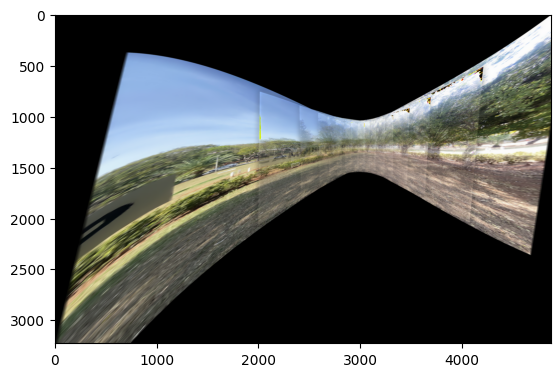

In [11]:

# Create and run stitcher
stitcher = PanoramaStitcher()
imgs = [cv2.resize(heif2jpg(p), (0, 0), fx=.25, fy=.25) for p in scene_path]
panorama = stitcher.stitch(imgs[:12])

if panorama is not None:
    plt.imshow(panorama)